In [75]:
from comet_ml import Experiment
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
import torch
from torchsummary import summary
torch.cuda.set_device(0)

hyper_params = {
    "stage": 4,
    "num_classes": 10,
    "batch_size": 64,
    "num_epochs": 100,
    "learning_rate": 1e-4
}

In [76]:
path = untar_data(URLs.IMAGENETTE)

In [77]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train = 'train', valid = 'val', bs = hyper_params["batch_size"], size = 224, ds_tfms = tfms).normalize(imagenet_stats)

In [78]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)
learn = learn.load('unfreeze_imagenet_bs64')
learn.freeze()
# learn.summary()

class Flatten(nn.Module) :
    def forward(self, input):
        return input.view(input.size(0), -1)

def conv2(ni, nf) : 
    return conv_layer(ni, nf, stride = 2)

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        
    def forward(self, x): 
        return (x + self.conv1(x))

def conv_and_res(ni, nf): 
    return nn.Sequential(conv2(ni, nf), ResBlock(nf))

def conv_(nf) : 
    return nn.Sequential(conv_layer(nf, nf), ResBlock(nf))
    
net = nn.Sequential(
    conv_layer(3, 64, ks = 7, stride = 2, padding = 3),
    nn.MaxPool2d(3, 2, padding = 1),
    conv_(64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    AdaptiveConcatPool2d(),
    Flatten(),
    nn.Linear(2 * 512, 256),
    nn.Linear(256, hyper_params["num_classes"])
)

net.cpu()
net.load_state_dict(torch.load('../saved_models/stage4/model0.pt', map_location = 'cpu'))

if torch.cuda.is_available() : 
    net = net.cuda()
    print('Model on GPU')
    
for name, param in net.named_parameters() : 
    print(name, param.shape)
    param.requires_grad = False
    if name[0] == str(hyper_params['stage']):
        param.requires_grad = True
    print(param.requires_grad)

Model on GPU
0.0.weight torch.Size([64, 3, 7, 7])
False
0.2.weight torch.Size([64])
False
0.2.bias torch.Size([64])
False
2.0.0.weight torch.Size([64, 64, 3, 3])
False
2.0.2.weight torch.Size([64])
False
2.0.2.bias torch.Size([64])
False
2.1.conv1.0.weight torch.Size([64, 64, 3, 3])
False
2.1.conv1.2.weight torch.Size([64])
False
2.1.conv1.2.bias torch.Size([64])
False
3.0.0.weight torch.Size([128, 64, 3, 3])
False
3.0.2.weight torch.Size([128])
False
3.0.2.bias torch.Size([128])
False
3.1.conv1.0.weight torch.Size([128, 128, 3, 3])
False
3.1.conv1.2.weight torch.Size([128])
False
3.1.conv1.2.bias torch.Size([128])
False
4.0.0.weight torch.Size([256, 128, 3, 3])
True
4.0.2.weight torch.Size([256])
True
4.0.2.bias torch.Size([256])
True
4.1.conv1.0.weight torch.Size([256, 256, 3, 3])
True
4.1.conv1.2.weight torch.Size([256])
True
4.1.conv1.2.bias torch.Size([256])
True
5.0.0.weight torch.Size([512, 256, 3, 3])
False
5.0.2.weight torch.Size([512])
False
5.0.2.bias torch.Size([512])
False

In [79]:
# x, y = next(iter(data.train_dl))
# net(torch.autograd.Variable(x).cuda())
summary(net, (3, 224, 224))
# print(learn.summary())
# net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
              ReLU-2         [-1, 64, 112, 112]               0
       BatchNorm2d-3         [-1, 64, 112, 112]             128
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
              ReLU-6           [-1, 64, 56, 56]               0
       BatchNorm2d-7           [-1, 64, 56, 56]             128
            Conv2d-8           [-1, 64, 56, 56]          36,864
              ReLU-9           [-1, 64, 56, 56]               0
      BatchNorm2d-10           [-1, 64, 56, 56]             128
         ResBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12          [-1, 128, 28, 28]          73,728
             ReLU-13          [-1, 128, 28, 28]               0
      BatchNorm2d-14          [-1, 128,

In [80]:
class SaveFeatures :
    def __init__(self, m) : 
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp) : 
        self.features = outp
    def remove(self) :
        self.handle.remove()
        
# saving outputs of all Basic Blocks
mdl = learn.model
sf = [SaveFeatures(m) for m in [mdl[0][2], mdl[0][4], mdl[0][5], mdl[0][6], mdl[0][7]]]
sf2 = [SaveFeatures(m) for m in [net[0], net[2], net[3], net[4], net[5]]]

In [81]:
x, y = next(iter(data.train_dl))
x = torch.autograd.Variable(x).cuda()
out1 = mdl(x)
out2 = net(x)
for i in range(5) : 
    print(sf[i].features.shape)
    assert(sf[i].features.shape == sf2[i].features.shape)
del x, y

torch.Size([64, 64, 112, 112])
torch.Size([64, 64, 56, 56])
torch.Size([64, 128, 28, 28])
torch.Size([64, 256, 14, 14])
torch.Size([64, 512, 7, 7])


#### Stage-wise training

In [ ]:
experiment = Experiment(api_key="IOZ5docSriEdGRdQmdXQn9kpu",
                        project_name="kd0", workspace="akshaykvnit")
experiment.log_parameters(hyper_params)
optimizer = torch.optim.Adam(net.parameters(), lr = hyper_params["learning_rate"])
total_step = len(data.train_ds) // hyper_params["batch_size"]
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(hyper_params["num_epochs"]):
    trn = []
    net.train()
    for i, (images, labels) in enumerate(data.train_dl) :
        if torch.cuda.is_available():
            images = torch.autograd.Variable(images).cuda().float()
            labels = torch.autograd.Variable(labels).cuda()
        else : 
            images = torch.autograd.Variable(images).float()
            labels = torch.autograd.Variable(labels)

        y_pred = net(images)
        y_pred2 = mdl(images)

        loss = F.mse_loss(sf[hyper_params["stage"]].features, sf2[hyper_params["stage"]].features)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(net.parameters(), 10)
        optimizer.step()

        if i % 50 == 49 :
            print('epoch = ', epoch, ' step = ', i + 1, ' of total steps ', total_step, ' loss = ', loss.item())

    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)

    net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(data.valid_dl) :
            if torch.cuda.is_available():
                images = torch.autograd.Variable(images).cuda().float()
                labels = torch.autograd.Variable(labels).cuda()
            else : 
                images = torch.autograd.Variable(images).float()
                labels = torch.autograd.Variable(labels)

            # Forward pass
            y_pred = net(images)
            y_pred2 = mdl(images)
            loss = F.mse_loss(sf[hyper_params["stage"]].features, sf2[hyper_params["stage"]].features)
            val.append(loss.item())

    val_loss = sum(val) / len(val)
    val_loss_list.append(val_loss)
    print('epoch : ', epoch + 1, ' / ', hyper_params["num_epochs"], ' | TL : ', train_loss, ' | VL : ', val_loss)
    experiment.log_metric("train_loss", train_loss)
    experiment.log_metric("val_loss", val_loss)

    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(net.state_dict(), '../saved_models/stage5/model0.pt')

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/akshaykvnit/kd0/1556f88fb55f4689a271a6e165f23946
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory    : (4394975232.0, 4394975232.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11721506816.0, 11721506816.0)
COMET INFO:     sys.gpu.0.used_memory    : (7326531584.0, 7326531584.0)
COMET INFO:     sys.gpu.1.free_memory    : (6221987840.0, 6221987840.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory   : (6233391104.0, 6233391104.0)
COMET INFO:     sys.gpu.1.used_memory    : (11403264.0, 11403264.0)
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/akshaykvnit/kd0/f0a8a5adb3504c6eabee95bc918182d7



epoch =  0  step =  50  of total steps  201  loss =  1.8529632091522217
epoch =  0  step =  100  of total steps  201  loss =  1.5440667867660522
epoch =  0  step =  150  of total steps  201  loss =  1.5738344192504883
epoch =  0  step =  200  of total steps  201  loss =  1.6611530780792236
epoch :  1  /  100  | TL :  1.7752577798876596  | VL :  1.9239202439785004
saving model
epoch =  1  step =  50  of total steps  201  loss =  2.3517138957977295
epoch =  1  step =  100  of total steps  201  loss =  2.8368022441864014
epoch =  1  step =  150  of total steps  201  loss =  1.4077677726745605
epoch =  1  step =  200  of total steps  201  loss =  1.4739136695861816
epoch :  2  /  100  | TL :  1.7654415431307322  | VL :  1.9452775940299034
epoch =  2  step =  50  of total steps  201  loss =  1.7814961671829224
epoch =  2  step =  100  of total steps  201  loss =  1.459864854812622
epoch =  2  step =  150  of total steps  201  loss =  1.0374197959899902
epoch =  2  step =  200  of total step

In [5]:
# learn = Learner(data, net, metrics = accuracy)
net.cpu()
net.load_state_dict(torch.load('../saved_models/stage4/model0.pt', map_location = 'cpu'))
net = net.cuda()

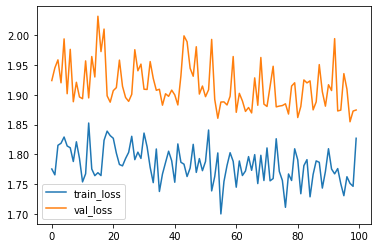

In [83]:
plt.plot(range(hyper_params["num_epochs"]), train_loss_list, label = 'train_loss') 
plt.plot(range(hyper_params["num_epochs"]), val_loss_list, label = 'val_loss')
plt.legend()
plt.savefig('../figures/stage4/train_loss.jpg')

#### Evaluation